In [75]:
import os
import torch
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch.mps 
import itertools
import csv
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import torchvision.models as models
from torchvision.models import ResNet18_Weights


# plt.ion() 
plt.gray()


<Figure size 640x480 with 0 Axes>

In [76]:
# %%time
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("MPS found")
    device = torch.device("mps")
    

MPS found


In [77]:
class FERPlusDataset(Dataset):
    """FERPlus dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.classes = self.img_frame.iloc[:, 2:].shape[1]

    def __len__(self):
        return len(self.img_frame)

#     to access elements using the []
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

#   to create the image name
        img_name = os.path.join(self.root_dir, self.img_frame.iloc[idx, 0])

        image = io.imread(img_name)
        # image = io.imread(image)
        image = Image.fromarray(image)

        emotions = self.img_frame.iloc[idx, 2:]
        emotions = np.asarray(emotions)
        emotions = emotions.astype('float32')

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'emotions': emotions} # a dictionary of an image with its label
        
        return sample #return a transformed image with label

In [78]:
torch.manual_seed(17) #https://pytorch.org/vision/stable/transforms.html

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
    ]),
}

# data_transforms = {
#     'train': transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485], std=[0.229]),
#     ]),
#     'valid': transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485], std=[0.229]),
#     ]),
# }

In [79]:
train_folder_path = './data/FER2013Train'
test_folder_path = './data/FER2013Test'
valid_folder_path = './data/FER2013Valid'

In [80]:
train_dataset = FERPlusDataset(csv_file= os.path.join(train_folder_path,"label.csv"), root_dir=train_folder_path, transform=data_transforms['train'])
valid_dataset = FERPlusDataset(csv_file= os.path.join(valid_folder_path, "label.csv"), root_dir= valid_folder_path, transform=data_transforms['valid'])
test_dataset = FERPlusDataset(csv_file= os.path.join(test_folder_path, "label.csv"), root_dir= test_folder_path, transform=data_transforms['valid'])

In [ ]:
def train_and_validate(epochs, optimizer, scheduler ,criterion, model, trainloader, validloader, learning_rate,):
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []
    opt_name = optimizer.__name__
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    
    if scheduler == optim.lr_scheduler.ReduceLROnPlateau:
        scheduler = scheduler(optimizer)
        # print("plateu")
        # print(type(scheduler))
        
    elif scheduler == optim.lr_scheduler.ExponentialLR: 
        scheduler = scheduler(optimizer, gamma=0.9)
        # print(type(scheduler))
        
    st = time.time()

# Training - Validation loop
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()
        # Perform training
        for i, data in enumerate(trainloader, 0):
            labels = data['emotions'].to(device)
            inputs = data['image'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # Calculate and store training accuracy
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)
            # for performance, you can max in data prep for consistency, 
            total += inputs.size(0)
            correct +=  (predicted == labels).sum().item()
        scheduler.step()
        train_loss.append(running_loss / len(trainloader))
        train_accuracy.append(100 * correct / total)
        # Perform validation
        model.eval()
        correct = 0
        total = 0
        running_loss = 0.0
        with torch.inference_mode():
            for data in validloader:
                labels = data['emotions'].to(device)
                inputs = data['image'].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                _, labels = torch.max(labels, 1)
                total += inputs.size(0)
                correct +=  (predicted == labels).sum().item() #can be torch.eq(pred, labels).sum().item()
        
        valid_loss.append(running_loss / len(validloader))
        valid_accuracy.append(100 * correct / total)
        
        # Print the training and validation loss and accuracy
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Training Loss: {train_loss[-1]:.4f} | Training Accuracy: {train_accuracy[-1]:.2f}%')
        print(f'Validation Loss: {valid_loss[-1]:.4f} | Validation Accuracy: {valid_accuracy[-1]:.2f}%')
        print('-----------------------------------')

    # elapsed_time = time.time() - st
    print('Finished Training')
    # with open(f'{outputs_path}/statistics.csv', 'a', newline='') as csvfile:
    #     writer = csv.writer(csvfile)

    #     if csvfile.tell() == 0:
    #         # Write the column headers
    #         writer.writerow(['trial', 'Batch size', 'Epochs', 'Activation function', 'Loss function', 'Initial Learning rate', 'Optimizer', 'Scheduler',
    #                         'Min training accuracy', 'Max training accuracy', 'Average training accuracy',
    #                         'Min validation accuracy', 'Max validation accuracy', 'Average validation accuracy',
    #                         'Total time', 'device'])

In [81]:
# Define parameter grids
criterion = nn.CrossEntropyLoss()
optimizer = [optim.SGD, optim.Adam]
activation = [F.relu, F.sigmoid]
learning_rate = [0.001, 0.01, 0.1]
epochs = 100
batch_size = 32
scheduler = optim.lr_scheduler.ExponentialLR
device = torch.device("mps")

In [82]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
class Net(nn.Module):
        def __init__(self, drop=0.2):
            super().__init__()
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
        # output size = 6 *44*44 values 
        # image size : n*n 
        # filter size: f*f (f is odd number)
        # shrinked_image size : (n - f + 1)^2 

            self.bn1 = nn.BatchNorm2d(6)  # Batch normalization after conv1
            
            self.pool = nn.MaxPool2d(2, 2)
        # default stride is 2 because it was not specified so defaults to kernel size which is 2
        # output size = ((n-f+1)/2)^2 = 22*22 *6  
            
            self.conv2 = nn.Conv2d(6, 16, 5)
        #output size = 18 * 18 * 16 = 5184   
            
            self.bn2 = nn.BatchNorm2d(16)  # Batch normalization after conv2
            
            self.fc1 = nn.Linear(16 * 9 * 9, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)
            
            self.dropout = nn.Dropout(p=drop)
            
        def forward(self, x):
            x = self.pool(F.relu(self.bn1(self.conv1(x)))) 
            # 44*44*6 , 22*22*6 
            
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            # 18*18*16 , 9*9*16 
            
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.dropout(self.fc1(x)))
            # x = self.dropout(x)
            x = F.relu(self.dropout(self.fc2(x)))
            # x = self.dropout(x)
            x = self.fc3(x)
            # x = F.softmax(x, dim=1)
            return x

In [ ]:
torch.manual_seed(42)
torch.mps.manual_seed(42) #do I need it ? wasn't in the current stats
my_model = Net()
# model.load_state_dict()
my_model.to(device)

# print(my_model.state_dict)

In [ ]:
# train_and_validate(epochs, optimizer, scheduler , criterion, my_model, trainloader, validloader,learning_rate)

In [ ]:
# torch.save(my_model.state_dict(), './models/myCNN_noAug_30_epochs.pth')

In [ ]:
# # dictionary for classess names in FERplus dataset
classes_map = {
    0: 'Neutral',
    1: 'Happinnes',
    2: 'Surprise',
    3: 'Sadness',
    4: 'Anger',
    5: 'Disgust',
    6: 'Fear',
    7: 'Contempt',
    8: 'Unknown',
    9: 'NF'
}

In [ ]:
# Neutral = 0
# Happinnes = 0
# Surprise = 0
# Sadness = 0
# Anger = 0
# Disgust = 0
# Fear = 0
# Contempt = 0
# Unknown = 0
# NF = 0
# total = 0

# # count classes in train_dataset


# for batch in testloader: 
#     # for data in batch['emotions']:
#     labels = batch['emotions']
#     # print(labels.shape)
#     _, labels = torch.max(labels,1)
#     for label in labels: 
#         # print(label)
#         new_label = classes[label.item()]
#         total +=1
#         if new_label == classes[0]: 
#             Neutral +=1 
#         elif new_label == classes[1]:
#             Happinnes +=1
#         elif new_label == classes[2]:
#             Surprise +=1
#         elif new_label == classes[3]:
#             Sadness +=1
#         elif new_label == classes[4]:
#             Anger +=1
#         elif new_label == classes[5]:
#             Disgust +=1
#         elif new_label == classes[6]:
#             Fear +=1
#         elif new_label == classes[7]:
#             Contempt +=1
#         elif new_label == classes[8]:
#             Unknown +=1
#         elif new_label == classes[9]:
#             NF +=1

# print(f" Happiness: {Happinnes}, Nuetral : {Neutral}, Anger: {Anger}, Sadness: {Sadness}, Fear: {Fear}, Disgust: {Disgust}, Contempt: {Contempt}, NF: {NF}, Unknown: {Unknown}")  
# print(f"total: {total}")                  

In [ ]:
# idx = 100
# for idx in range(100):
#     np_img = train_dataset[idx]['image']
#     plt.imshow(np.transpose(np_img, (1, 2, 0)))
#     plt.show()
#     plt.close()
#     print("image:",idx,  'truth:', classes[train_dataset[idx]['emotions'].argmax(0)])

In [73]:
my_model = Net()
my_model.load_state_dict(torch.load('./stats/CNNs-2/models/trial_2.pth'))
# my_model.load_state_dict(torch.load('./models/CNN/trial_25.pth'))

my_model.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [83]:
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_classes = train_dataset.classes
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
# model.load_state_dict(torch.load('./models/RESNET/RESNET-18_11.pth'))
model.load_state_dict(torch.load('./stats/RESNET-Final/models/trial_3.pth'))

model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=10).to(device)

In [ ]:
out_file = 'model.txt'

In [84]:
classes = [
    'Neutral',
    'Happinnes',
    'Surprise',
    'Sadness',
    'Anger',
    'Disgust',
    'Fear',
    'Contempt',
    'Unknown', 
    # 'NF'
]

Evaluation Metrics:
average accuracy : 67.89%
F1 Score: 66.96%
Precision: 67.16%
Recall: 67.92%


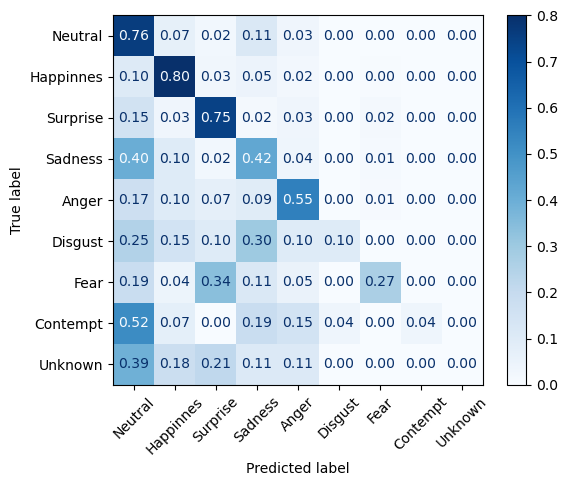

In [85]:
# test model on the test data set
import torch.nn.functional as F
import torch
def test_model(model, test_loader):
    model.to('cpu')
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    test_accuracy = []
    predicted_labels=[]
    true_labels = []
    
    wrong = 0
    with torch.inference_mode():
        for i, data in enumerate(test_loader):
            labels = data['emotions']
            inputs = data['image']
            output = model(inputs)
            # print("out: ", output.shape)
            # print("labels: ", labels.shape)
            # print(labels.shape)
            # print(f"test loader length:  {len(test_loader)}")
            # show the first 10 images and their truth labels and their predictions
            # if i < len(test_loader):
            #     for j in range(len(inputs)):
                    # if classes[labels[j].argmax(0).item()] != classes[output[j].argmax(0).item()] :
                    #     wrong +=1
                    
                    # output_file = open(out_file, "a")
                    # prediction = classes[labels[j].argmax(0).item()] == classes[output[j].argmax(0).item()]
                    
                    # output_file.write(f"image: {i * batch_size + j} was {prediction}\n")
                    # output_file.write(f"predicted label was: {classes[output[j].argmax(0).item()]} and the original label was {classes[labels[j].argmax(0).item()]}\n")
                    # output_file.write("="*50)
                    # output_file.write("\n")
                    # if j == 10:
                    #     print("one example:")
                    #     np_img = test_dataset[i * batch_size + j]['image']
                    #     plt.imshow(np.transpose(np_img, (1, 2, 0)))
                    #     plt.show()
                    #     plt.close()
                    #     print('-'*50)
                        
                    # print(labels[i].argmax().item())
                    # if classes[labels[j].argmax(0).item()] == classes[output[j].argmax(0).item()]:
                    #     print("hoppppaaaaaaaaaa")
                    #     print('image:', i * batch_size + j)
                        
                    #     print('truth:', classes[labels[j].argmax(0).item()])
                    #     print('prediction:', classes[output[j].argmax(0).item()])
                    #     print('='*50)
                    # plt.close('all')    
            # output_file.close()
            # measure accuracy
            _, predicted = torch.max(output, 1)
            _, labels = torch.max(labels, 1)
            # torchmetrics_accuracy(predicted, labels)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_accuracy.append(torchmetrics_accuracy(predicted, labels))
            
            # Store predicted and true labels for calculating metrics
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
        # print(f"labels pred: {len(predicted_labels) }")
        # print(f"labeld true: {len(true_labels) }")
            
            # Calculate evaluation metrics
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
        recall = recall_score(true_labels, predicted_labels, average='weighted')
        # confusion_mat = confusion_matrix(true_labels, predicted_labels)
        # ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, normalize='true', display_labels=classes, cmap='Blues', xticks_rotation=45.0)
        
        cm_display = ConfusionMatrixDisplay.from_predictions(y_true=true_labels, y_pred=predicted_labels, normalize='true', display_labels=classes, cmap='Blues', values_format='0.2f', xticks_rotation=45)
        fig, ax = plt.subplots(figsize=(10,8))
        cm_display.plot(ax=ax)

        # Save the plot to a file
        save_path = 'confusion_matrix3.png'  # Specify the desired save path
        plt.savefig(save_path)
        
        
        
        # Log evaluation metrics
        print("Evaluation Metrics:")
        print(f"average accuracy : {100* (sum(test_accuracy) / len(test_accuracy)):.2f}%")
        print(f"F1 Score: {100* f1 :.2f}%")
        print(f"Precision: {100* precision :.2f}%")
        print(f"Recall: {100* recall :.2f}%")
        # print("Confusion Matrix:")
        # print(confusion_mat)
        # # sns.heatmap(confusion_mat, annot=True, cmap="Blues")
        # # disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=classes, xticks_rotation='vertical',normalize='true' )
        # # disp.plot()
        # # plt.show()
        
        # # print total accuracy
        # print('Accuracy of the network on the test images: %d %%' % (
        #     100 * correct / total))
        # print(f"correct: {correct}, total: {total}")
        # print(test_accuracy)
        # print(sum(test_accuracy) / len(test_accuracy))
test_model(my_model, test_loader=testloader)
plt.close()

In [ ]:
model

In [ ]:
# test model on the test data set
import torch.nn.functional as F
import torch
def test_model(model, test_loader):
    model.to('cpu')
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    test_accuracy = []
    predicted_labels=[]
    true_labels = []
    
    wrong = 0
    with torch.inference_mode():
        for i, data in enumerate(test_loader):
            labels = data['emotions']
            inputs = data['image']
            output = model(inputs)
            # print("out: ", output.shape)
            # print("labels: ", labels.shape)
            # print(labels.shape)
            # print(f"test loader length:  {len(test_loader)}")
            # show the first 10 images and their truth labels and their predictions
            # if i < len(test_loader):
            #     for j in range(len(inputs)):
                    # if classes[labels[j].argmax(0).item()] != classes[output[j].argmax(0).item()] :
                    #     wrong +=1
                    
                    # output_file = open(out_file, "a")
                    # prediction = classes[labels[j].argmax(0).item()] == classes[output[j].argmax(0).item()]
                    
                    # output_file.write(f"image: {i * batch_size + j} was {prediction}\n")
                    # output_file.write(f"predicted label was: {classes[output[j].argmax(0).item()]} and the original label was {classes[labels[j].argmax(0).item()]}\n")
                    # output_file.write("="*50)
                    # output_file.write("\n")
                    # if j == 10:
                    #     print("one example:")
                    #     np_img = test_dataset[i * batch_size + j]['image']
                    #     plt.imshow(np.transpose(np_img, (1, 2, 0)))
                    #     plt.show()
                    #     plt.close()
                    #     print('-'*50)
                        
                    # print(labels[i].argmax().item())
                    # if classes[labels[j].argmax(0).item()] == classes[output[j].argmax(0).item()]:
                    #     print("hoppppaaaaaaaaaa")
                    #     print('image:', i * batch_size + j)
                        
                    #     print('truth:', classes[labels[j].argmax(0).item()])
                    #     print('prediction:', classes[output[j].argmax(0).item()])
                    #     print('='*50)
                    # plt.close('all')    
            # output_file.close()
            # measure accuracy
            _, predicted = torch.max(output, 1)
            _, labels = torch.max(labels, 1)
            # torchmetrics_accuracy(predicted, labels)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_accuracy.append(torchmetrics_accuracy(predicted, labels))
            
            # Store predicted and true labels for calculating metrics
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
        # print(f"labels pred: {len(predicted_labels) }")
        # print(f"labeld true: {len(true_labels) }")
            
            # Calculate evaluation metrics
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
        recall = recall_score(true_labels, predicted_labels, average='weighted')
        # confusion_mat = confusion_matrix(true_labels, predicted_labels)
        # ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, normalize='true', display_labels=classes, cmap='Blues', xticks_rotation=45.0)
        
        cm_display = ConfusionMatrixDisplay.from_predictions(y_true=true_labels, y_pred=predicted_labels, normalize='true', display_labels=classes, cmap='Blues', values_format='0.2f', xticks_rotation=45)
        fig, ax = plt.subplots(figsize=(10,8))
        cm_display.plot(ax=ax)

        # Save the plot to a file
        save_path = 'confusion_matrix3.png'  # Specify the desired save path
        plt.savefig(save_path)
        
        
        
        # Log evaluation metrics
        print("Evaluation Metrics:")
        print(f"average accuracy : {100* (sum(test_accuracy) / len(test_accuracy)):.2f}%")
        print(f"F1 Score: {100* f1 :.2f}%")
        print(f"Precision: {100* precision :.2f}%")
        print(f"Recall: {100* recall :.2f}%")
        # print("Confusion Matrix:")
        # print(confusion_mat)
        # # sns.heatmap(confusion_mat, annot=True, cmap="Blues")
        # # disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=classes, xticks_rotation='vertical',normalize='true' )
        # # disp.plot()
        # # plt.show()
        
        # # print total accuracy
        # print('Accuracy of the network on the test images: %d %%' % (
        #     100 * correct / total))
        # print(f"correct: {correct}, total: {total}")
        # print(test_accuracy)
        # print(sum(test_accuracy) / len(test_accuracy))
test_model(my_model, test_loader=testloader)
plt.close()

In [ ]:
# idx = 388

# np_img = test_dataset[idx]['image']
# plt.imshow(np.transpose(np_img, (1, 2, 0)))
# plt.show()
# plt.close()
# print (f"the original label was {classes[test_dataset[idx]['emotions'].argmax(0).item()]}\n")


1- data augmentation 
2- maxing before ?
3- 

questions: 

1- how should the final product look like? 
2- should i investigate data augmentation? 
3- how about transfer learning? any advice? 
4- REPORT, how should it look like? any examples? any guidance is appreciated
5- in general, what do you think? 

genetic programming (evolutionary algorithms) 

leaky Relu and param Relu

regularization 

torch metrics 